# Inferring Rings in Crops

In [ ]:
#all_slow

Here we demonstrate the inference capability of the ring-counter model on crops of antinodes to see what "physics" can be learned from the additional 12,000 images not included in the labeled 'cleaner' dataset. 
(The crops are obtained from the bounding boxes prediced by the IceVision bounding box object detector.)

> Note: This section reads requires access to the full 14,000 (previously unlabeled) video frames, which are not part of our dataset release. If this is a point of contention for reviewers, temporary access to these frames will be  enabled so that these graphs can be reproduced. However for now, these data are considered "proprietary". 

In [ ]:
#hide
#Run once per session 
!pip install fastai espiownage mrspuff typing_extensions -q --upgrade

In [ ]:
import espiownage
from espiownage.core import *
sysinfo()
print(f"espiownage version {espiownage.__version__}")

TORCH_VERSION=torch1.9.0; CUDA_VERSION=cu102
CUDA available = True, Device count = 1, Current device = 0
Device name = GeForce RTX 2080 Ti
hostname: lecun
espiownage version 0.0.41


In [ ]:
from fastai.vision.all import *

In [ ]:
from fastcore.foundation import L
from fastcore.xtras import Path # @patch'd properties to the Pathlib module

from fastai.callback.fp16 import to_fp16
from fastai.callback.schedule import fit_one_cycle, lr_find 
from fastai.data.external import untar_data, URLs

from fastai.data.block import RegressionBlock, DataBlock
from fastai.data.transforms import get_image_files, Normalize, RandomSplitter, parent_label

from fastai.interpret import ClassificationInterpretation
from fastai.learner import Learner # imports @patch'd properties to Learner including `save`, `load`, `freeze`, and `unfreeze`
from fastai.optimizer import ranger

from fastai.vision.augment import aug_transforms, RandomResizedCrop, Resize, ResizeMethod
from fastai.vision.core import imagenet_stats
from fastai.vision.data import ImageBlock
from fastai.vision.learner import cnn_learner
from fastai.vision.utils import download_images, verify_images

from mrspuff.utils import on_colab

In [ ]:
#slow
dataset_name = 'cleaner'
path = get_data('cleaner'); path

/home/drscotthawley/datasets/espiownage-cleaner/crops


## Define the Original dls
To set up the dataloader.... this isn't technically necessary but it's the only way I know how. 

In [ ]:
fnames = get_image_files(path)
print(f"{len(fnames)} total cropped images")
ind = 1  # pick one cropped image
print(fnames[ind])

def label_func(x):  
    return round(float(x.stem.split('_')[-1]),2)

print(label_func(fnames[ind]))

cropsize = (300,300) # pixels
croppedrings = DataBlock(blocks=(ImageBlock, RegressionBlock(n_out=1)),
                    get_items=get_image_files,
                    splitter=RandomSplitter(),
                    get_y=label_func,
                    item_tfms=Resize(cropsize, ResizeMethod.Squish),
                    batch_tfms=[*aug_transforms(size=cropsize, flip_vert=True, max_rotate=360.0), 
                    Normalize.from_stats(*imagenet_stats)])

dls = croppedrings.dataloaders(path, bs=32)

6614 total cropped images
/home/drscotthawley/datasets/espiownage-cleaner/crops/06241902_proc_00618_0_36_76_255_11.0.png
11.0


## Define the model & load weights

In [ ]:
opt = ranger
y_range=(0.2,13)  # balance between "clamping" to range of real data vs too much "compression" from sigmoid nonlinearity
learn = cnn_learner(dls, resnet34, n_out=1, y_range=y_range, 
                    loss_func=MSELossFlat(), opt_func=opt)
learn.load('crop-rings-real_k0')

/home/drscotthawley/envs/espi/lib/python3.6/site-packages/torch/nn/functional.py:718: UserWarning:

Named tensors and all their associated APIs are an experimental feature and subject to change. Please do not use them for anything important until they are released as stable. (Triggered internally at  /pytorch/c10/core/TensorImpl.h:1156.)



## Do the predictions

In [ ]:
crop_dir = 'crops_iv'  
pfnames = sorted(glob.glob(crop_dir+'/*.png')) # files to predict on
print(f"{len(pfnames)} image crops to predict on.")b

30980 image crops to predict on.


file =  crops_iv/06241902_proc_01659_142_82_280_219.png


We're guessing 8.324728965759277 rings for this one:


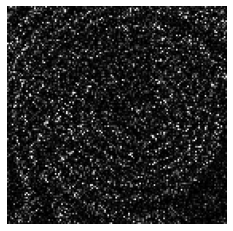

In [ ]:
# pick one and look at it
ind = 30102 # len(pfnames)//4+1
pf = pfnames[ind]
print("file = ",pf)
im = PILImage.create(pf)
im.show() 
pred, _ = learn.get_preds(dl=dls.test_dl([pfnames[ind]]))
print(f"We're guessing {pred.squeeze().cpu().numpy()} rings for this one:")

### Now do it in BULK!

In [ ]:
# new test dataloader
dlpred = dls.test_dl(pfnames)

# do the inference
preds, _ = learn.get_preds(dl=dlpred)

# inspect what we got, and 
print(preds.shape)
preds = preds.squeeze(1)
print(preds.shape)

torch.Size([30980, 1])
torch.Size([30980])


In [ ]:
preds = preds.cpu().numpy()

AttributeError: 'numpy.ndarray' object has no attribute 'cpu'

## Explore the data

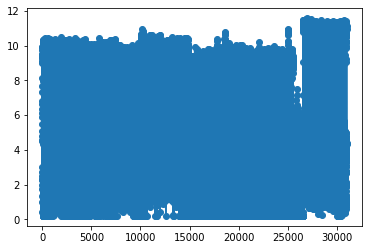

In [ ]:
plt.plot(preds,'-o')

In [ ]:
fs_imgdir = '/home/drscotthawley/datasets/zooniverse_steelpan/' # where all full size images are stored
imlist = [os.path.basename(x) for x in sorted(glob.glob(fs_imgdir+'/*.png'))]

name2frame= {v:int(k) for k,v in enumerate(imlist)} # map filename to frame number

In [ ]:
name2frame['06240907_proc_00243.png']

243

save a CSV, send it on

In [ ]:
# col_names = ['cx', 'cy', 'filename', 'rings', 'a', 'b', 'angle']

results = []
for i, pfile in enumerate(pfnames):
    rings = preds[i]
    pfile = str(Path(pfile).stem)
    splits = pfile.split('_')
    filename = splits[0]+'_proc_'+splits[2]+'.png'
    bbox = [int(x) for x in splits[3:]]
    cx, cy = (bbox[0]+bbox[2])/2, (bbox[1]+bbox[3])/2
    a, b, = bbox[2]-bbox[0], bbox[3]-bbox[1]
    angle = 0   # because who knows, right?
    line_list = [cx, cy, filename, rings, a, b, angle, bbox]
    results.append(line_list)

In [ ]:
# store as pandas dataframe
res_df = pd.DataFrame(results, columns=['cx', 'cy', 'filename', 'rings', 'a', 'b', 'angle', 'bbox'])
print(len(res_df))
res_df.head()

30980


cx     cy                 filename     rings    a    b  angle  \
0  74.0  154.0  06240907_proc_00243.png  7.337386  140  242      0   
1  77.0  160.0  06240907_proc_00244.png  7.690507  140  256      0   
2  46.5  169.0  06240907_proc_00250.png  4.556321   93  248      0   
3  94.5  221.5  06240907_proc_00252.png  2.292115  135  153      0   
4  98.5  216.0  06240907_proc_00261.png  2.989285  145  152      0   

                  bbox  
0    [4, 33, 144, 275]  
1    [7, 32, 147, 288]  
2     [0, 45, 93, 293]  
3  [27, 145, 162, 298]  
4  [26, 140, 171, 292]

In [ ]:
abbrev_df = res_df[['cx', 'cy', 'filename', 'rings', 'a', 'b', 'angle']]
abbrev_df.head()
abbrev_df.to_csv('espiownage-ml-annotations.csv', index=False)

## Explore the Data

In [ ]:
df = res_df # more convenient name 

In [ ]:
def is_in_box(
    p,     # a point as a (x,y) coordinate pair 
    bb,    # a bounding box of the form [xmin,ymin,xmax,ymax]
    ):
    "Is this point within that bounding box?"
    x, y = p 
    return (x>=bb[0]) and (x<=bb[2]) and (y>=bb[1]) and (y<=bb[3])

In [ ]:
assert is_in_box((100,100),(10,30,180,50)) == False
assert is_in_box((100,100),(10,30,180,150)) == True

In [ ]:
# pick a point
p = (216, 139)  # same example as segmentation regression
df['p_in_box'] = [is_in_box(p,x) for x in df['bbox']]
print(f"We have {df['p_in_box'].sum()} bounding boxes (i.e frames) containing that point")
#df['haverings'] = truelines
df['rings_at_p'] = df['p_in_box']*df['rings']
df.iloc[29644:29649]

We have 3831 bounding boxes (i.e frames) containing that point


cx     cy                 filename      rings    a    b  angle  \
29644   44.0  136.0  06241902_proc_01494.png  10.903073   86  214      0   
29645  207.5  146.5  06241902_proc_01495.png   5.524946  145  145      0   
29646  228.0  289.0  06241902_proc_01495.png   1.355684  106  104      0   
29647   44.5  132.0  06241902_proc_01495.png  11.421818   87  218      0   
29648  206.0  149.0  06241902_proc_01496.png   3.553706  138  136      0   

                       bbox  p_in_box  rings_at_p  
29644      [1, 29, 87, 243]     False    0.000000  
29645   [135, 74, 280, 219]      True    5.524946  
29646  [175, 237, 281, 341]     False    0.000000  
29647      [1, 23, 88, 241]     False    0.000000  
29648   [137, 81, 275, 217]      True    3.553706

06241902_proc_01495.png


<AxesSubplot:>

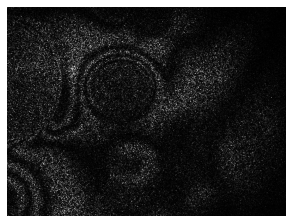

In [ ]:
# focus on that image 
print(imlist[13495])
im = PILImage.create(fs_imgdir+'/'+imlist[13495])
im.show() 

In [ ]:
r_vs_t = np.zeros(14000)-1
for i, row in df.iterrows():
    fname, rings = row['filename'], row['rings']
    if '06241902_proc_01495' in fname:
        print("fname, rings = ",fname, rings)
    framenum = name2frame[fname]
    if row['p_in_box']: r_vs_t[framenum] = rings
print(r_vs_t[13495])

fname, rings =  06241902_proc_01495.png 5.524946212768555
fname, rings =  06241902_proc_01495.png 1.3556838035583496
fname, rings =  06241902_proc_01495.png 11.421817779541016
5.524946212768555


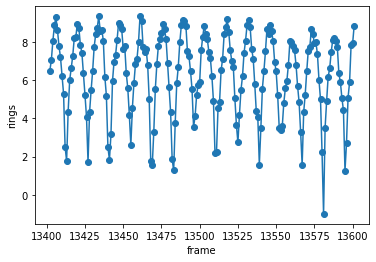

In [ ]:
start, end = 13502-100, 13502+100
plt.plot(range(start,end),r_vs_t[start:end],'o-')
plt.ylabel('rings')
plt.xlabel('frame')
plt.show()

Save that to a file that we can combine with the seg-reg graph:

In [ ]:
np.savetxt('rings_vs_t_13400-13600.txt',r_vs_t[start:end])